# Faster R-CNN (ResNet50-FPN, Pretrained ImageNet) on C2A_Dataset

- Two-stage detector
- Backbone: ResNet50 + FPN (pretrained=ImageNet)
- RPN: Generate Regions
- RoI Pooling + FC Layers
- Optimizer: SGD
- Loss: Multi-task Loss (RPN obj + RPN bbox + ROI cls + ROI bbox)

This notebook sets up a Faster R-CNN model, runs quick inference, and visualizes: 
- Feature map heatmaps from 3 layers (ResNet layer1/layer2/layer3)
- Dense layer activations (fc6, fc7 in ROI head) as bar plots
for at least 5 images (3 similar results, 2 different).

In [1]:
#%pip install -q torchvision matplotlib --quiet
import os, json, random, math
from collections import defaultdict, Counter
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Dataset: COCO-style JSON in C2A_Dataset/new_dataset3
We will read `train/val/test` splits from COCO-style JSONs (`*_annotations.json`) and image folders.
For simplicity, all categories are treated as class `1` (person) to match a 1-class detector (background+1).

In [2]:
DATASET_ROOT = './C2A_Dataset/new_dataset3'

class CocoSimpleDataset(Dataset):
    def __init__(self, root, split='test', transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        img_dir = os.path.join(root, split, 'images')
        ann_path = os.path.join(root, split, f'{split}_annotations.json')
        assert os.path.exists(img_dir), f'Missing {img_dir}'
        assert os.path.exists(ann_path), f'Missing {ann_path}'
        with open(ann_path, 'r') as f:
            data = json.load(f)
        # index images
        self.images = {im['id']: im for im in data.get('images', [])}
        # group annotations per image
        anns_per_img = defaultdict(list)
        for ann in data.get('annotations', []):
            anns_per_img[ann['image_id']].append(ann)
        self.ids = list(self.images.keys())
        self.img_dir = img_dir
        self.anns_per_img = anns_per_img
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.images[img_id]
        path = os.path.join(self.img_dir, info['file_name'])
        img = Image.open(path).convert('RGB')
        # Build boxes (COCO bbox is [x,y,w,h]) and labels (map any category to 1)
        boxes, labels = [], []
        for a in self.anns_per_img.get(img_id, []):
            x,y,w,h = a['bbox']
            boxes.append([x, y, x+w, y+h])
            labels.append(1)
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if len(boxes)>0 else torch.zeros((0,4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if len(labels)>0 else torch.zeros((0,), dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torchvision.transforms.ToTensor()(img)  # 0..1 tensor
        return img, target

In [3]:
# Build datasets and loaders (safer settings for Windows)
import torchvision.transforms as T
from torch.utils.data import Subset

# Toggle a tiny subset for quick debug to avoid OOM during development
TINY_DEBUG = True  # set True for a very small subset run

# Use only ToTensor() so targets (boxes) remain in original coordinates
transform = T.ToTensor()

train_ds = CocoSimpleDataset(DATASET_ROOT, 'train', transform)
val_ds   = CocoSimpleDataset(DATASET_ROOT,   'val', transform)
test_ds  = CocoSimpleDataset(DATASET_ROOT,  'test', transform)

# Optionally shrink datasets for a very fast, memory-safe debug cycle
if TINY_DEBUG:
    train_ds = Subset(train_ds, list(range(min(120, len(train_ds)))))
    val_ds   = Subset(val_ds,   list(range(min(40, len(val_ds)))))

# Use num_workers=0 to avoid multiprocessing issues on Windows
# Reduce batch_size to prevent OOM
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=0)

print(f"Dataset sizes (post-subset if enabled): train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")
len(train_ds), len(val_ds), len(test_ds)

Dataset sizes (post-subset if enabled): train=120, val=40, test=2043


(120, 40, 2043)

## Model: Faster R-CNN with ResNet50-FPN (pretrained=ImageNet)
Optimizer: SGD, Loss: multi-task (built-in).

In [ ]:
# Create a lighter pretrained backbone and model with reduced proposals for stability
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

def build_light_model(num_classes=2):
    # Prefer a smaller backbone if available; otherwise freeze most layers of resnet50
    try:
        backbone = resnet_fpn_backbone('resnet18', pretrained=True, trainable_layers=0)  # tiniest with FPN
        print('Using resnet18 FPN (trainable_layers=0)')
    except Exception as e:
        print('resnet18 FPN unavailable, falling back to resnet50 FPN:', e)
        backbone = resnet_fpn_backbone('resnet50', pretrained=True, trainable_layers=1)  # mostly frozen
    model = FasterRCNN(backbone, num_classes=num_classes)
    
    # Reduce RPN pre/post NMS proposals to lower memory and speed up
    if hasattr(model, 'rpn') and hasattr(model.rpn, 'pre_nms_top_n_train'):
        model.rpn.pre_nms_top_n_train = 1000
        model.rpn.post_nms_top_n_train = 300
        model.rpn.pre_nms_top_n_test = 600
        model.rpn.post_nms_top_n_test = 300
        print('Adjusted RPN proposal counts.')
    
    # Reduce max detections per image
    if hasattr(model, 'roi_heads') and hasattr(model.roi_heads, 'detections_per_img'):
        model.roi_heads.detections_per_img = 100
        print('Set detections_per_img = 100')
    
    return model

num_classes = 2  # background + 1 class
model = build_light_model(num_classes=num_classes)
model.to(device)

# Optimizer (SGD) – only trainable params
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002, momentum=0.9, weight_decay=5e-4)
print('Lihtweight model ready')

Using resnet18 FPN (trainable_layers=0)
Set detections_per_img = 100


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Lightweight model ready


## Optional: quick warm-up training (few iterations)
You can skip this if only visualization is needed.

In [5]:
def train_steps(model, optimizer, loader, device, max_steps=20):
    model.train()
    steps = 0
    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        optimizer.step()
        steps += 1
        if steps % 5 == 0:
            print(f'Step {steps}: loss={loss.item():.4f}')
        if steps >= max_steps:
            break

# Uncomment to run a tiny warm-up
# train_steps(model, optimizer, train_loader, device, max_steps=10)

## Visualization hooks: feature maps (layer1, layer2, layer3) and dense activations (fc6, fc7)

In [6]:
from collections import defaultdict
feature_maps = defaultdict(list)
dense_acts = defaultdict(list)  # will hold lists per image forward

# Register hooks on backbone ResNet layers
def save_fmap(name):
    def hook(module, inp, out):
        feature_maps[name].append(out.detach().cpu().clone())  # store per-forward
    return hook

# Access resnet body inside backbone
resnet_body = model.backbone.body
h1 = resnet_body.layer1.register_forward_hook(save_fmap('layer1'))
h2 = resnet_body.layer2.register_forward_hook(save_fmap('layer2'))
h3 = resnet_body.layer3.register_forward_hook(save_fmap('layer3'))

# Hooks for ROI head dense layers (TwoMLPHead: fc6, fc7)
def save_dense(name, post_relu=False):
    def hook(module, inp, out):
        t = torch.relu(out) if post_relu else out
        dense_acts[name].append(t.detach().cpu().clone())  # [num_rois, 1024] per forward
    return hook

h_fc6 = model.roi_heads.box_head.fc6.register_forward_hook(save_dense('fc6', post_relu=False))
h_fc7 = model.roi_heads.box_head.fc7.register_forward_hook(save_dense('fc7', post_relu=False))
print('Hooks registered (per-image append)')

def reset_hooks_buffers():
    feature_maps.clear(); dense_acts.clear()

Hooks registered (per-image append)


## Helper functions: predict, heatmaps, and activation plots

In [7]:
def tensor_to_np(img_tensor):
    # img_tensor: [C,H,W] in 0..1
    img = img_tensor.detach().cpu().permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)
    return img

@torch.no_grad()
def run_inference_with_hooks(model, img_tensor):
    model.eval()
    preds = model([img_tensor.to(device)])  # triggers hooks
    return preds[0]

def show_feature_maps(fmaps, titles=('layer1','layer2','layer3')):
    plt.figure(figsize=(15,4))
    for i, k in enumerate(titles):
        lst = fmaps.get(k, [])
        if not lst:
            plt.subplot(1,3,i+1); plt.title(k+' (no data)'); plt.axis('off'); continue
        fmap = lst[-1]  # last appended
        if fmap.dim() == 4:
            fmap = fmap[0]
        heat = fmap.mean(dim=0).numpy()  # channel-mean
        plt.subplot(1,3,i+1)
        plt.imshow(heat, cmap='hot')
        plt.title(k)
        plt.axis('off')
    plt.tight_layout(); plt.show()

def show_dense_activations(dacts, topk=32, agg='first'):
    # Show bar plots for fc6 and fc7 (top-k absolute activations)
    plt.figure(figsize=(16,5))
    for i, k in enumerate(['fc6','fc7']):
        lst = dacts.get(k, [])
        if not lst:
            vals = np.zeros(topk)
        else:
            acts = lst[-1]  # tensor [num_rois, 1024]
            if acts.numel() == 0:
                vals = np.zeros(topk)
            else:
                if agg == 'mean':
                    vec = acts.mean(dim=0).numpy()
                else:
                    vec = acts[0].numpy()  # take first ROI
                idxs = np.argsort(-np.abs(vec))[:topk]
                vals = vec[idxs]
        plt.subplot(1,2,i+1)
        plt.bar(range(len(vals)), vals)
        plt.title(f'{k} top-{topk} activations ({agg})')
        plt.xlabel('unit index (sorted)'); plt.ylabel('activation')
    plt.tight_layout(); plt.show()

def draw_detections(ax, img_np, pred, score_thr=0.5):
    ax.imshow(img_np); ax.axis('off')
    boxes = pred['boxes'].cpu().numpy() if pred['boxes'].numel()>0 else []
    scores = pred['scores'].cpu().numpy() if 'scores' in pred else []
    for b, s in zip(boxes, scores):
        if s < score_thr: continue
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f'{s:.2f}', color='yellow', fontsize=8, backgroundcolor='black')

def signature(pred):
    # simple signature: (det_count_above_0.5, avg_score_above_0.5)
    if 'scores' not in pred or pred['scores'].numel()==0:
        return (0, 0.0)
    scores = pred['scores'].cpu().numpy()
    m = scores >= 0.5
    cnt = int(m.sum())
    avg = float(scores[m].mean()) if cnt>0 else 0.0
    return (cnt, avg)

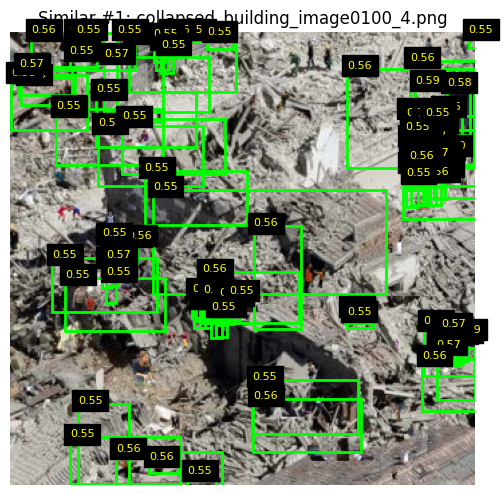

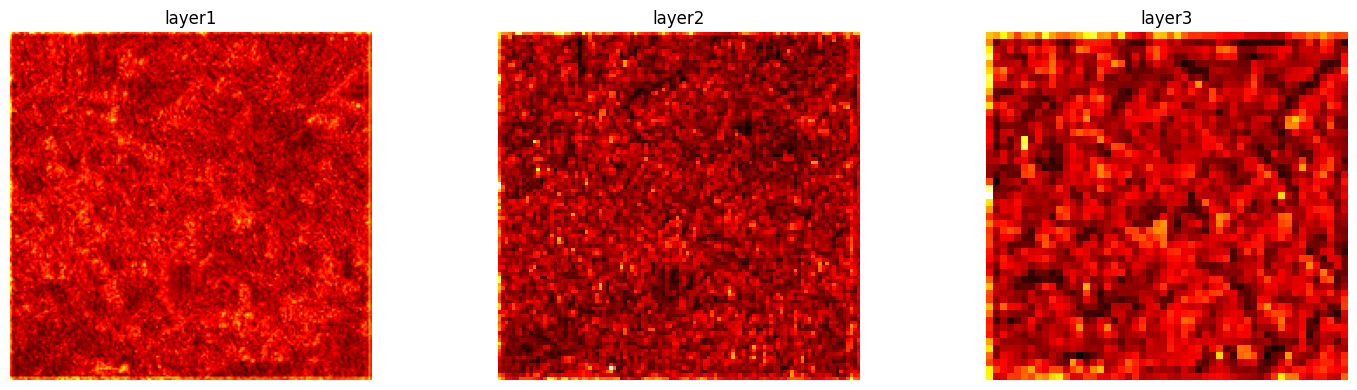

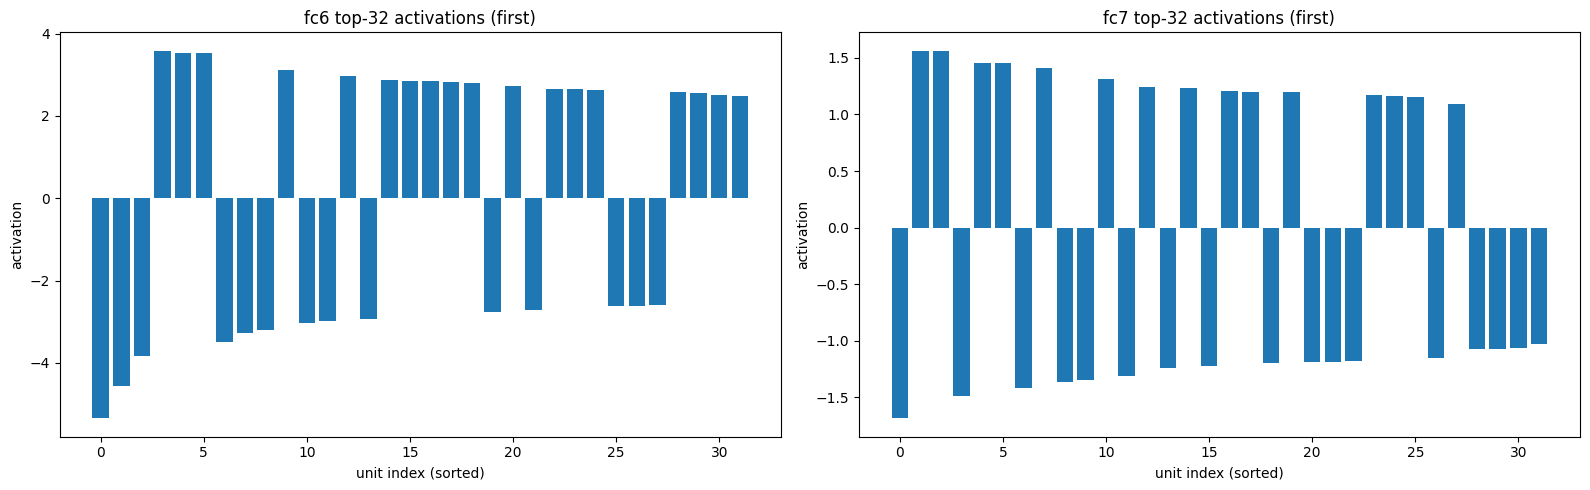

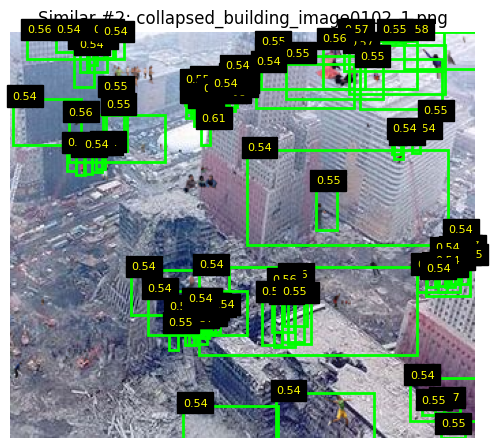

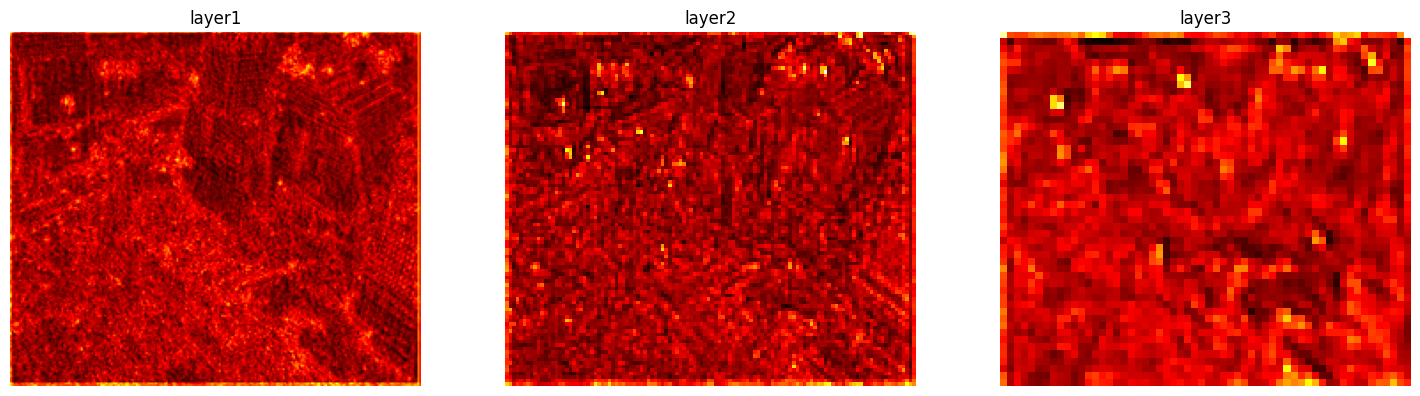

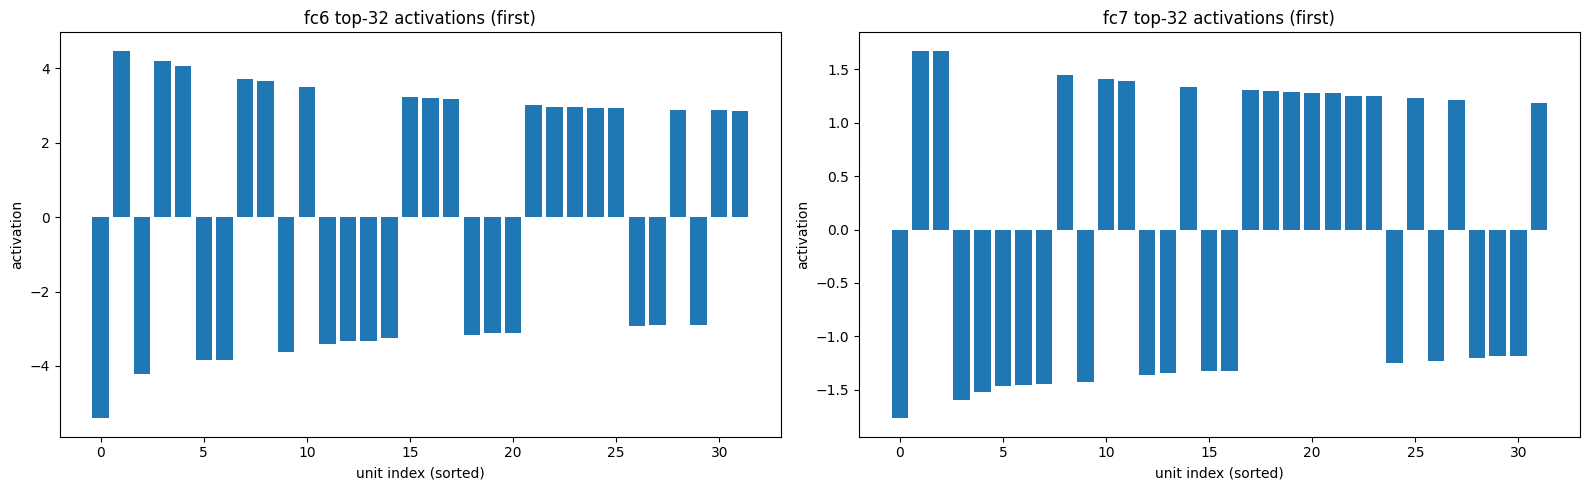

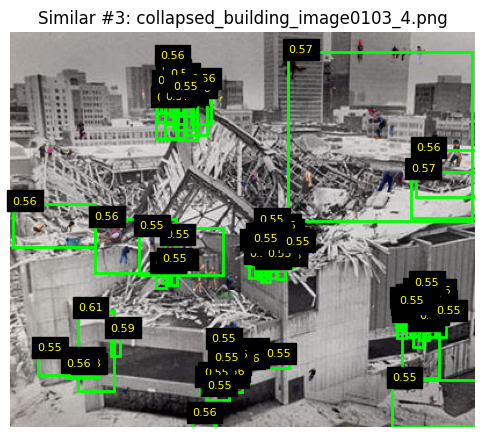

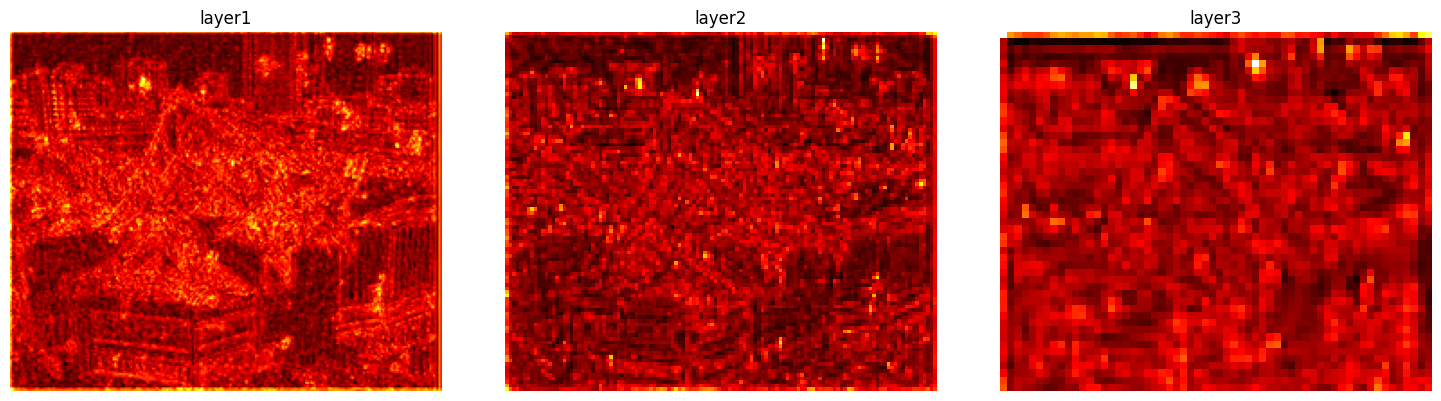

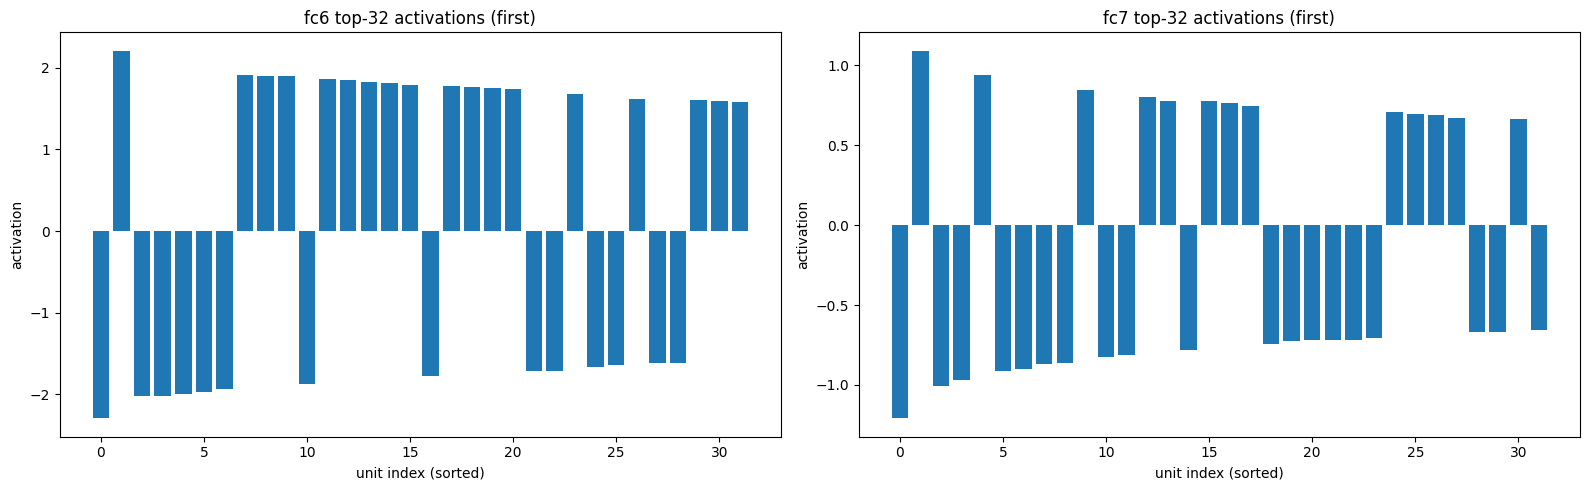

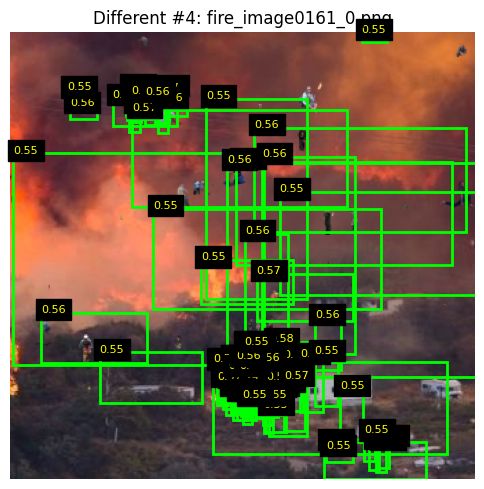

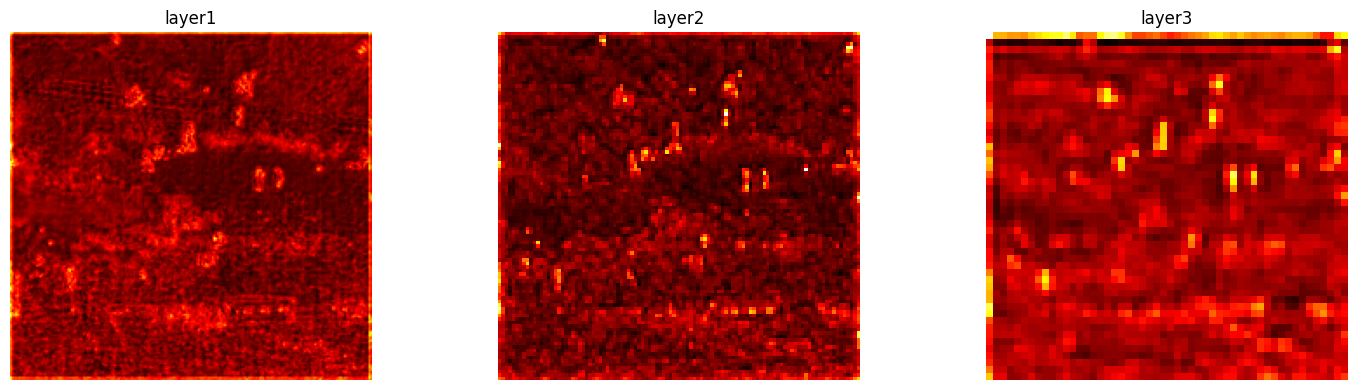

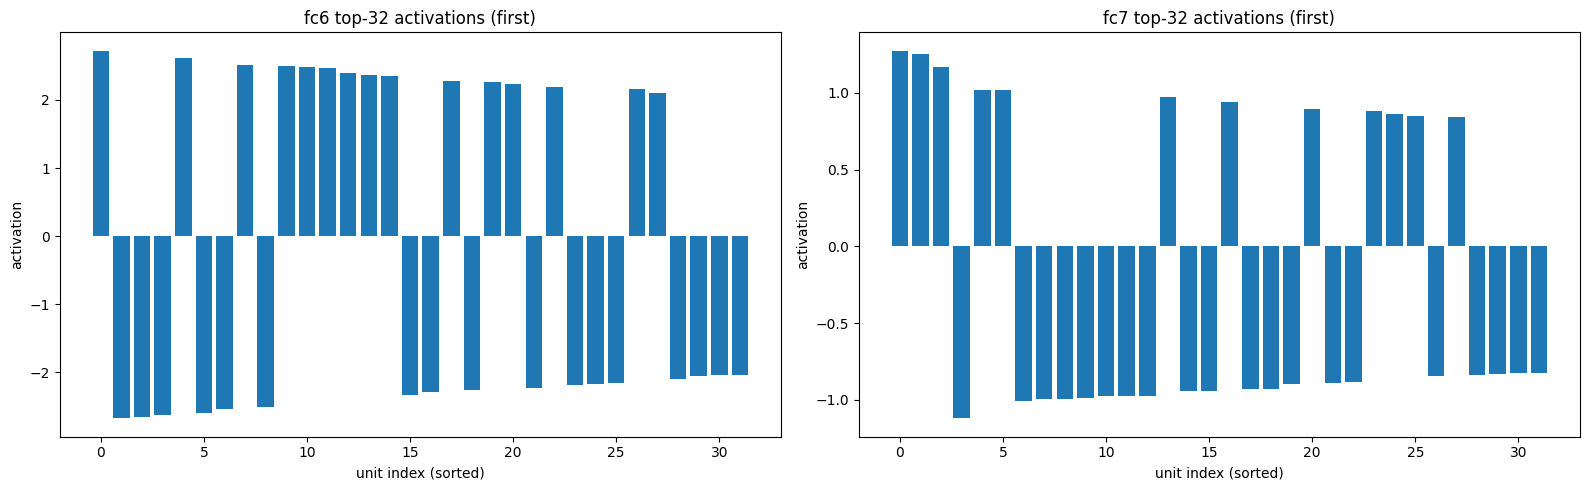

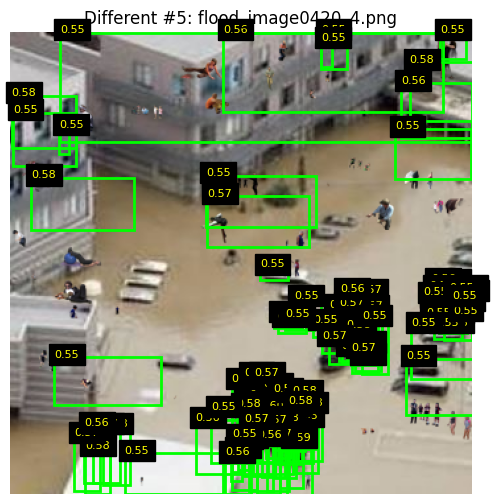

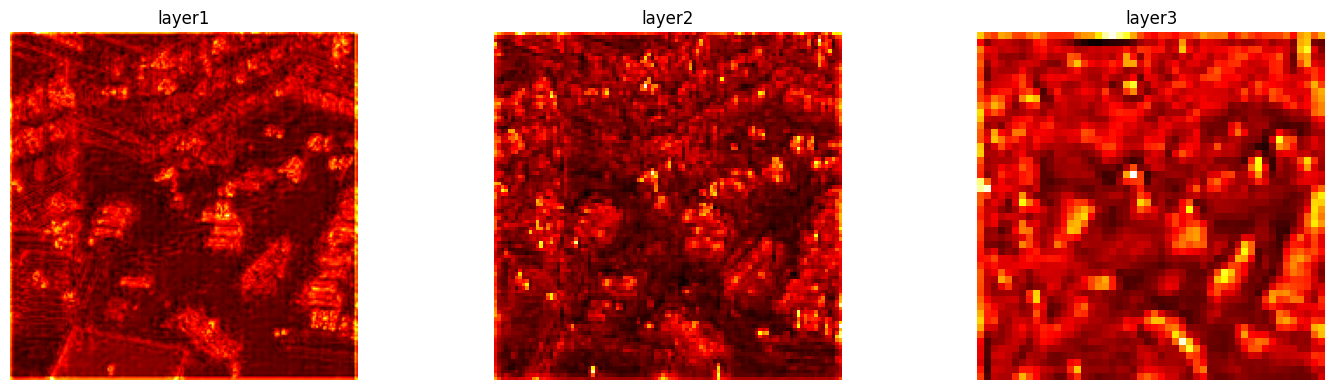

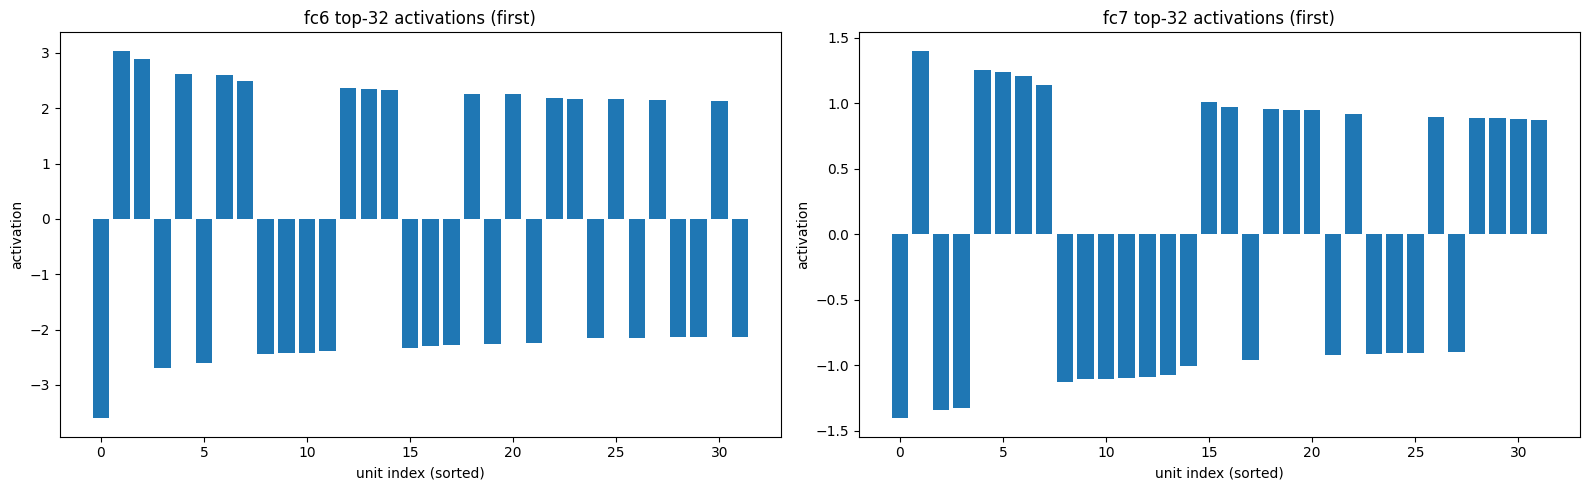

In [8]:
# Configure folder and filenames
SELECTED_DIR = './C2A_selected'
selected_similar = [
    'collapsed_building_image0100_4.png',
    'collapsed_building_image0102_1.png',
    'collapsed_building_image0103_4.png',
]
selected_different = [
    'fire_image0161_0.png',
    'flood_image0420_4.png',
]
selected_all = selected_similar + selected_different

# Helper to load an arbitrary image path as tensor like dataset does
from PIL import Image

def load_image_as_tensor(path):
    img = Image.open(path).convert('RGB')
    return torchvision.transforms.ToTensor()(img)

# Make sure folder exists and files are present
assert os.path.isdir(SELECTED_DIR), f'Missing folder: {SELECTED_DIR}'
for fn in selected_all:
    fp = os.path.join(SELECTED_DIR, fn)
    assert os.path.exists(fp), f'Missing file: {fp}'

# Visualize in order: first 3 similar, then 2 different
for rank, fn in enumerate(selected_all, 1):
    reset_hooks_buffers()  # clear per-image stored tensors
    img_path = os.path.join(SELECTED_DIR, fn)
    img_t = load_image_as_tensor(img_path)

    pred = run_inference_with_hooks(model, img_t)
    img_np = tensor_to_np(img_t)

    # Show detections for this file
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    draw_detections(ax, img_np, pred, score_thr=0.5)
    tag = 'Similar' if fn in selected_similar else 'Different'
    ax.set_title(f'{tag} #{rank}: {fn}')
    plt.show()

    # Feature map heatmaps (3 layers) - using latest captured
    show_feature_maps(feature_maps, titles=('layer1','layer2','layer3'))

    # Dense layer activations (fc6, fc7) - first ROI by default
    show_dense_activations(dense_acts, topk=32, agg='first')

## Train and Evaluate with Metrics
We will train Faster R-CNN for a few epochs and report:
- Loss (training)
- "Accuracy" as Recall@0.5 IoU on validation
- MAE/MSE of bbox coordinates for matched pairs (x1,y1,x2,y2)
- R2 score between matched predicted vs ground-truth coordinates

Notes:
- Detection "accuracy" is approximated as Recall at IoU≥0.5.
- Metrics are computed on validation set after each epoch.

In [9]:
import time
from typing import List, Tuple

# IoU computation

def box_iou_xyxy(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    # a: [Na, 4], b: [Nb, 4]
    if a.numel() == 0 or b.numel() == 0:
        return torch.zeros((a.shape[0], b.shape[0]), dtype=torch.float32)
    x1 = torch.max(a[:, None, 0], b[None, :, 0])
    y1 = torch.max(a[:, None, 1], b[None, :, 1])
    x2 = torch.min(a[:, None, 2], b[None, :, 2])
    y2 = torch.min(a[:, None, 3], b[None, :, 3])
    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
    area_a = (a[:, 2] - a[:, 0]).clamp(min=0) * (a[:, 3] - a[:, 1]).clamp(min=0)
    area_b = (b[:, 2] - b[:, 0]).clamp(min=0) * (b[:, 3] - b[:, 1]).clamp(min=0)
    union = area_a[:, None] + area_b[None, :] - inter
    iou = inter / union.clamp(min=1e-6)
    return iou

# Match predictions to ground truths by IoU≥thr with greedy matching

def match_by_iou(pred_boxes: torch.Tensor, gt_boxes: torch.Tensor, iou_thr: float = 0.5) -> List[Tuple[int, int, float]]:
    matches = []
    if pred_boxes.numel() == 0 or gt_boxes.numel() == 0:
        return matches
    ious = box_iou_xyxy(pred_boxes, gt_boxes)
    used_pred = set()
    used_gt = set()
    # Greedy: pick highest IoU pairs first
    flat = []
    for i in range(ious.shape[0]):
        for j in range(ious.shape[1]):
            flat.append((float(ious[i, j]), i, j))
    flat.sort(reverse=True)
    for iou, i, j in flat:
        if iou < iou_thr:
            break
        if i in used_pred or j in used_gt:
            continue
        used_pred.add(i); used_gt.add(j)
        matches.append((i, j, iou))
    return matches

# Validation metrics on a loader

@torch.no_grad()
def evaluate_val(model, loader, device, score_thr=0.5, iou_thr=0.5):
    model.eval()
    total_gt = 0
    total_matched = 0
    # For regression metrics over matched pairs
    all_pred_coords = []
    all_gt_coords = []

    for images, targets in loader:
        img = images[0].to(device)
        target = {k: v.to(device) for k, v in targets[0].items()}

        # Use mixed precision for inference too
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = model([img])[0]
        
        # Filter by score
        keep = out['scores'] >= score_thr if 'scores' in out else torch.zeros(0, dtype=torch.bool, device=device)
        p_boxes = out['boxes'][keep].detach().cpu()
        g_boxes = target['boxes'].detach().cpu()

        total_gt += g_boxes.shape[0]
        matches = match_by_iou(p_boxes, g_boxes, iou_thr=iou_thr)
        total_matched += len(matches)

        # Collect coordinates for MAE/MSE/R2 over matched pairs
        for (pi, gi, _iou) in matches:
            all_pred_coords.append(p_boxes[pi].numpy())
            all_gt_coords.append(g_boxes[gi].numpy())

    # Recall@IoU
    recall = (total_matched / total_gt) if total_gt > 0 else 0.0

    # Regression metrics
    def safe_stats(pred_list, gt_list):
        if len(pred_list) == 0:
            return 0.0, 0.0, 0.0
        P = np.stack(pred_list, axis=0)  # [N,4]
        G = np.stack(gt_list, axis=0)
        diff = P - G
        mae = float(np.mean(np.abs(diff)))
        mse = float(np.mean(diff**2))
        # R2 per coordinate, then mean
        r2s = []
        for k in range(P.shape[1]):
            y = G[:, k]
            yhat = P[:, k]
            ss_res = np.sum((y - yhat)**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r2 = 1 - ss_res / ss_tot if ss_tot > 1e-9 else 0.0
            r2s.append(r2)
        r2_mean = float(np.mean(r2s))
        return mae, mse, r2_mean

    mae, mse, r2 = safe_stats(all_pred_coords, all_gt_coords)
    return {
        'recall@0.5': recall,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'matched': len(all_pred_coords),
        'total_gt': int(total_gt)
    }

# Train for epochs and record history (with mixed precision + memory management)

def train_and_eval(model, optimizer, train_loader, val_loader, device, epochs=3):
    history = {
        'train_loss': [],
        'val_recall@0.5': [],
        'val_mae': [],
        'val_mse': [],
        'val_r2': []
    }
    
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        count = 0
        t0 = time.time()
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            try:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Mixed precision training
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    loss_dict = model(images, targets)
                    loss = sum(loss for loss in loss_dict.values())
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
                running += float(loss.item())
                count += 1
                
                # Clear cache periodically
                if torch.cuda.is_available() and batch_idx % 50 == 0:
                    torch.cuda.empty_cache()
                    
            except RuntimeError as e:
                print(f"❌ Training error at batch {batch_idx}: {e}")
                if torch.cuda.is_available():
                    print(f"Memory: {torch.cuda.memory_allocated(0) / 1024**2:.1f} MB")
                    torch.cuda.empty_cache()
                raise
        
        avg_loss = running / max(count, 1)
        
        # Eval with error handling
        try:
            metrics = evaluate_val(model, val_loader, device, score_thr=0.5, iou_thr=0.5)
        except Exception as e:
            print(f"❌ Validation error: {e}")
            metrics = {'recall@0.5': 0.0, 'mae': 0.0, 'mse': 0.0, 'r2': 0.0}
            
        dt = time.time() - t0
        print(f'Epoch {ep}: loss={avg_loss:.4f} | val_recall@0.5={metrics["recall@0.5"]:.3f} | MAE={metrics["mae"]:.3f} | MSE={metrics["mse"]:.3f} | R2={metrics["r2"]:.3f} | time={dt:.1f}s')

        history['train_loss'].append(avg_loss)
        history['val_recall@0.5'].append(metrics['recall@0.5'])
        history['val_mae'].append(metrics['mae'])
        history['val_mse'].append(metrics['mse'])
        history['val_r2'].append(metrics['r2'])
        
        # Clear cache after each epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    return history

# Plotting

def plot_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    # Loss
    axes[0].plot(history['train_loss'], marker='o'); axes[0].set_title('Train Loss'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    # Accuracy proxy: Recall
    axes[1].plot(history['val_recall@0.5'], marker='o'); axes[1].set_title('Accuracy (Recall@0.5)'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Recall')
    # Regression metrics (share axis)
    ax2 = axes[2]
    ax2.plot(history['val_mae'], label='MAE')
    ax2.plot(history['val_mse'], label='MSE')
    ax2.plot(history['val_r2'], label='R2')
    ax2.set_title('Regression Metrics (matched)')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.tight_layout(); plt.show()

print("✓ Train/eval functions loaded with safety improvements")

✓ Train/eval functions loaded with safety improvements


## Grad-CAM: visualize model focus on correct vs incorrect
We implement Grad-CAM on the backbone's `layer3` feature map.
Steps:
1) Run inference and pick a top-scoring detection as the target logit.
2) Backpropagate to `layer3` to get gradients; compute CAM = ReLU(weighted average of feature maps).
3) Overlay CAM on the image.
We show both a correct detection (IoU≥0.5 with any GT) and an incorrect one (IoU<0.5).

In [10]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.h_f = target_layer.register_forward_hook(self._forward_hook)
        self.h_b = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()
    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def remove(self):
        self.h_f.remove(); self.h_b.remove()

    def __call__(self, input_tensor, box_index=None, score_index=1):
        # input_tensor: [1,3,H,W] already on device
        self.model.eval()
        self.model.zero_grad()
        out = self.model(input_tensor)[0]
        if out['scores'].numel() == 0:
            return None, out
        # choose target detection
        idx = int(box_index) if box_index is not None else int(torch.argmax(out['scores']))
        # Classification logit: need a scalar - approximate by score
        score = out['scores'][idx]
        score.backward(retain_graph=True)
        # gradients: [1, C, H', W'], activations: [1, C, H', W']
        grads = self.gradients
        acts = self.activations
        if grads is None or acts is None:
            return None, out
        weights = grads.mean(dim=(2,3), keepdim=True)  # [1,C,1,1]
        cam = (weights * acts).sum(dim=1, keepdim=True)  # [1,1,H',W']
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
        return cam, out

def overlay_cam_on_image(img_np, cam):
    H, W = img_np.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))
    heatmap = cv2.applyColorMap((cam_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.4*heatmap.astype(np.float32) + 0.6*(img_np*255).astype(np.float32))
    overlay = np.clip(overlay/255.0, 0, 1)
    return overlay

@torch.no_grad()
def pick_cases_for_gradcam(model, loader, device, score_thr=0.5, iou_thr=0.5):
    # returns (correct_case, wrong_case) where case is (img_tensor, out, idx)
    correct = None
    wrong = None
    for images, targets in loader:
        img = images[0].to(device)
        target = {k: v.to(device) for k, v in targets[0].items()}
        out = model([img])[0]
        if out['scores'].numel() == 0:
            continue
        keep = out['scores'] >= score_thr
        if keep.sum() == 0:
            continue
        boxes = out['boxes'][keep].detach().cpu()
        scores = out['scores'][keep].detach().cpu()
        gt = target['boxes'].detach().cpu()
        ious = box_iou_xyxy(boxes, gt) if gt.numel() > 0 else torch.zeros((boxes.shape[0], 0))
        max_iou_per_pred, _ = (ious.max(dim=1) if gt.numel() > 0 else (torch.zeros(boxes.shape[0]), None))
        # mark any with IoU>=thr as correct
        for i in range(boxes.shape[0]):
            global_idx = int(torch.nonzero(keep).squeeze()[i])
            if max_iou_per_pred[i] >= iou_thr and correct is None:
                correct = (images[0], out, global_idx)
            if max_iou_per_pred[i] < iou_thr and wrong is None:
                wrong = (images[0], out, global_idx)
            if correct is not None and wrong is not None:
                return correct, wrong
    return correct, wrong

# Demo block (uncomment to run)
# target_layer = model.backbone.body.layer3
# gc = GradCAM(model, target_layer)
# correct_case, wrong_case = pick_cases_for_gradcam(model, val_loader, device)
# for label, case in [('Correct', correct_case), ('Incorrect', wrong_case)]:
#     if case is None: continue
#     img_t, out, idx = case
#     cam, _ = gc(img_t.unsqueeze(0).to(device), box_index=idx)
#     if cam is None: continue
#     img_np = tensor_to_np(img_t)
#     overlay = overlay_cam_on_image(img_np, cam)
#     fig, ax = plt.subplots(1,2, figsize=(10,5))
#     ax[0].imshow(img_np); ax[0].set_title(f'{label}: Image'); ax[0].axis('off')
#     ax[1].imshow(overlay); ax[1].set_title(f'{label}: Grad-CAM overlay'); ax[1].axis('off')
#     plt.show()
# gc.remove()

=== Environment Check ===
Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Torch: 2.7.1+cu118
CUDA available: True
GPU name: NVIDIA GeForce RTX 3080
CUDA memory allocated (MB): 117.9423828125
CUDA memory reserved (MB): 880.0

=== Single Batch Test (Safe) ===


C:\Users\PC\AppData\Local\Temp\ipykernel_16288\407092427.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\PC\AppData\Local\Temp\ipykernel_16288\407092427.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


✓ Single batch test passed! Loss: 3.1012
Single batch time: 0.448s
Peak memory (MB): 449.6

=== Start Training (Short) ===


C:\Users\PC\AppData\Local\Temp\ipykernel_16288\2479916909.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\PC\AppData\Local\Temp\ipykernel_16288\2479916909.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\PC\AppData\Local\Temp\ipykernel_16288\2479916909.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1: loss=1.4423 | val_recall@0.5=0.009 | MAE=1.206 | MSE=3.135 | R2=1.000 | time=8.5s
Epoch 2: loss=1.4594 | val_recall@0.5=0.136 | MAE=1.302 | MSE=3.750 | R2=1.000 | time=7.3s


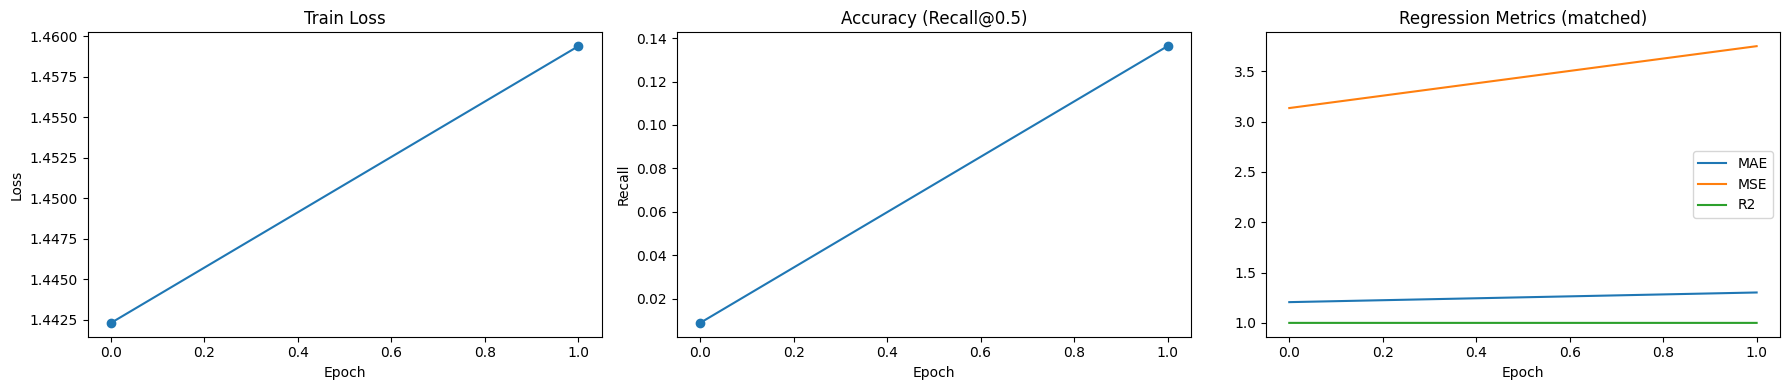

Saved checkpoint to checkpoints/fasterrcnn_ckpt.pth


In [ ]:
# Safe diagnostic check before full training
import subprocess, sys, time

print("=== Environment Check ===")
print("Python:", sys.version.splitlines()[0])
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    try:
        print("GPU name:", torch.cuda.get_device_name(0))
        print("CUDA memory allocated (MB):", torch.cuda.memory_allocated(0) / 1024**2)
        print("CUDA memory reserved (MB):", torch.cuda.memory_reserved(0) / 1024**2)
    except Exception as e:
        print("CUDA info error:", e)

print("\n=== Single Batch Test (Safe) ===")
# Test single batch with mixed precision to avoid crashes
from torch.utils.data import Subset
tiny_loader = DataLoader(Subset(train_ds, [0]), batch_size=1, shuffle=False, 
                        collate_fn=lambda x: tuple(zip(*x)), num_workers=0)

model.train()
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

try:
    t0 = time.time()
    for images, targets in tiny_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Use mixed precision to reduce memory usage
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        print(f"✓ Single batch test passed! Loss: {loss.item():.4f}")
        break
    
    dt = time.time() - t0
    print(f"Single batch time: {dt:.3f}s")
    
    if torch.cuda.is_available():
        print(f"Peak memory (MB): {torch.cuda.max_memory_allocated(0) / 1024**2:.1f}")
        torch.cuda.reset_peak_memory_stats()

except Exception as e:
    print(f"❌ Single batch failed: {e}")
    if torch.cuda.is_available():
        print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.1f} MB")
    raise

print("\n=== Start Training (Short) ===")
# Run training with safer settings
EPOCHS = 5  # Reduced epochs for safety
history = train_and_eval(model, optimizer, train_loader, val_loader, device, epochs=EPOCHS)
plot_history(history)

# Save checkpoint (recommended: state_dict + optimizer + history)
# import os
# os.makedirs('checkpoints', exist_ok=True)
# ckpt = {
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'history': history,
# }
# torch.save(ckpt, 'checkpoints/fasterrcnn_ckpt.pth')
# print('Saved checkpoint to checkpoints/fasterrcnn_ckpt.pth')

# To load later:
# ckpt = torch.load('checkpoints/fasterrcnn_ckpt.pth', map_location='cpu')
# model.load_state_dict(ckpt['model_state_dict'])
# optimizer.load_state_dict(ckpt['optimizer_state_dict'])